# Algorithm for Data Processing

1. Start
2. Read .csv file.
3. Create separate files for each state.
4. Is forecast year=year observed?
5. If yes, go to step 6. If no, go to step 9.
6. n=number of duplicates in Internal Project ID.
If Internal Project ID is unavailable, find duplicates by some other method.
7. New columns for Percentage Error.
8. Percentage Error=1/n*(Forecast-Actual)/Forecast. END
9. years=forecast year- year observed.
10. growth rate= difference between two projections/number of years in between projections.
11. adjusted forecast=forecast AADT X growth rate X years. Go to step 7.

## Step 1: Read Data File

Import necessary packages. 

In [1]:
import pandas as pd #for working with dataframe
import numpy as np
from scipy import stats, integrate #will help in stats operation in histograms
import matplotlib.pyplot as plt #to plot the PE
import seaborn as sns #nice looking plots
%matplotlib inline
sns.set(color_codes=True)

##### Read the CSV file. Look at Data. 

In [2]:
df=pd.read_csv("FlatData.csv",encoding='latin1')
df.groupby('State').count() #summary of the data available

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count
State,,,,,,,,,,,,,,,,,,
12.0,2066,1803,1923,0,1923,2066,2066,2066,2060,2066,2066,2060,2042,1188,2066,2066,2066,2066
27.0,38,38,38,0,38,38,38,38,38,38,38,38,38,32,38,38,38,38
28.0,2176,1565,0,0,2176,2176,1987,2176,2176,2176,2176,2176,2176,2176,2176,0,2176,2176
41.0,12411,0,12409,0,10677,12413,12413,12413,12413,12413,12413,12413,12413,12413,12413,0,12413,12413
58.0,0,0,457,0,457,457,457,457,457,457,457,457,457,0,457,0,457,457


## Step 2: Find a unique identifier for each project.
Some of the records in the database don't have any Internal Project ID number. We will need to analyse these differently. Create a new dataframe with only the rows that have a InternalProjectID.

In [3]:
df[df['InternalProjectID'].isnull()].groupby('State').count()

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count
State,,,,,,,,,,,,,,,,,,
12.0,143,0,0,0,0,143,143,143,143,143,143,143,143,143,143,143,143,143
41.0,1734,0,1736,0,0,1736,1736,1736,1736,1736,1736,1736,1736,1736,1736,0,1736,1736


There are 143+1734 rows without any InternalProjectID. 
#### Create a new dataframe with InternalProjectIDs.

In [4]:
flatdata_withID=df[df['InternalProjectID'].notnull()]
flatdata_withID #dataframe with IDs available.

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count
0,IR71/US 30 interchange Modification,NaN,1.0,NaN,41.0,11378,41-2-11378-IR71/US 30 interchange Modification,Richland,1,2000.0,37190,1.0,1994.0,6,", , RIC7119.08",2,NaN,2000,42310
1,IR71/US 30 interchange Modification,NaN,1.0,NaN,41.0,11378,41-2-11378-IR71/US 30 interchange Modification,Richland,1,2020.0,45190,3.0,1994.0,6,", , RIC7119.08",2,NaN,2008,39760
2,IR71/US 30 interchange Modification,NaN,3.0,NaN,41.0,11378,41-3-11378-IR71/US 30 interchange Modification,Richland,1,2000.0,12920,1.0,1994.0,6,", , RIC3017.2",3,NaN,2000,15780
3,IR71/US 30 interchange Modification,NaN,3.0,NaN,41.0,11378,41-3-11378-IR71/US 30 interchange Modification,Richland,1,2020.0,17390,3.0,1994.0,6,", , RIC3017.2",3,NaN,2008,15630
4,IR71/US 30 interchange Modification,NaN,1.0,NaN,41.0,11378,41-4-11378-IR71/US 30 interchange Modification,Richland,1,2000.0,37820,1.0,1994.0,6,", , RIC7118.78",4,NaN,2000,42450
5,IR71/US 30 interchange Modification,NaN,1.0,NaN,41.0,11378,41-4-11378-IR71/US 30 interchange Modification,Richland,1,2020.0,46060,3.0,1994.0,6,", , RIC7118.78",4,NaN,2008,39290
6,IR71/US 30 interchange Modification,NaN,1.0,NaN,41.0,11378,41-5-11378-IR71/US 30 interchange Modification,Richland,1,2000.0,16430,1.0,1994.0,6,", , RIC3016.87",5,NaN,2000,16530
7,IR71/US 30 interchange Modification,NaN,1.0,NaN,41.0,11378,41-5-11378-IR71/US 30 interchange Modification,Richland,1,2020.0,22090,3.0,1994.0,6,", , RIC3016.87",5,NaN,2008,18210
8,TUS-0036-15.730,NaN,3.0,NaN,41.0,19055,41-6-19055-TUS-0036-15.730,Tuscarawas,1,2000.0,8990,1.0,1999.0,6,", , TUS3615.73",6,NaN,2000,9100
9,TUS-0036-15.730,NaN,3.0,NaN,41.0,19055,41-6-19055-TUS-0036-15.730,Tuscarawas,1,2020.0,11530,3.0,1999.0,6,", , TUS3615.73",6,NaN,2010,8960


In [5]:
flatdata_withoutID=df[df['InternalProjectID'].isnull()]
flatdata_withoutID #dataframes without any ID, will have to analysed differently.

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count
208,CUY-71-6.68,NaN,1.0,NaN,41.0,NaN,41-106--CUY-71-6.68,Cuyahoga,1,2004.0,88310,1.0,2003.0,6,", , CUY715.21",106,NaN,2003,92550
209,CUY-71-6.68,NaN,1.0,NaN,41.0,NaN,41-106--CUY-71-6.68,Cuyahoga,1,2024.0,104720,3.0,2003.0,6,", , CUY715.21",106,NaN,2010,93650
210,CUY-71-6.68,NaN,1.0,NaN,41.0,NaN,41-107--CUY-71-6.68,Cuyahoga,1,2004.0,99150,1.0,2003.0,6,", , CUY715.52",107,NaN,2003,108520
211,CUY-71-6.68,NaN,1.0,NaN,41.0,NaN,41-107--CUY-71-6.68,Cuyahoga,1,2024.0,112650,3.0,2003.0,6,", , CUY715.52",107,NaN,2010,104340
212,CUY-71-6.68,NaN,1.0,NaN,41.0,NaN,41-108--CUY-71-6.68,Cuyahoga,1,2004.0,111280,1.0,2003.0,6,", , CUY716.68",108,NaN,2003,116790
213,CUY-71-6.68,NaN,1.0,NaN,41.0,NaN,41-108--CUY-71-6.68,Cuyahoga,1,2024.0,123940,3.0,2003.0,6,", , CUY716.68",108,NaN,2010,110160
214,CUY-71-6.68,NaN,1.0,NaN,41.0,NaN,41-109--CUY-71-6.68,Cuyahoga,1,2004.0,114080,1.0,2003.0,6,", , CUY718.84",109,NaN,2003,119890
215,CUY-71-6.68,NaN,1.0,NaN,41.0,NaN,41-109--CUY-71-6.68,Cuyahoga,1,2024.0,124140,3.0,2003.0,6,", , CUY718.84",109,NaN,2010,114050
362,CUY-271-13.45,NaN,1.0,NaN,41.0,NaN,41-183--CUY-271-13.45,Cuyahoga,1,2005.0,109490,1.0,2003.0,6,", , CUY27113.45",183,NaN,2007,103890
363,CUY-271-13.45,NaN,1.0,NaN,41.0,NaN,41-183--CUY-271-13.45,Cuyahoga,1,2025.0,150870,3.0,2003.0,6,", , CUY27113.45",183,NaN,2010,113670


Exclude Ohio (State ID= 41) dataset. They don't actually indicate whether the actual counts are taken after the project was completed or not, that is why the acccuracy assessment may not be entirely correct. Looking at the Ohio dataset, we see that in the original excel worksheetthere is a column titled "Physical Works Completed On". If the Near Opening Year Count happens before this date, that means the count is taken when the project is not yet done. SO we have to exclude these values. Ohio dataset will have to be analysed separately.

In [6]:
flatdata_withID=df[df['State']!=41.0]
flatdata_withID

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count
12413,NaN,NaN,3.0,NaN,58.0,1663,58-6231-1663-,Washington,1,2010.0,5300,1.0,2007.0,1,NaN,6231,NaN,2010,3700
12414,NaN,NaN,3.0,NaN,58.0,1663,58-6232-1663-,Washington,1,2010.0,7400,1.0,2007.0,1,NaN,6232,NaN,2010,5500
12415,NaN,NaN,3.0,NaN,58.0,1663,58-6233-1663-,Washington,1,2010.0,4150,1.0,2007.0,1,NaN,6233,NaN,2010,2800
12416,NaN,NaN,3.0,NaN,58.0,1663,58-6234-1663-,Washington,1,2010.0,3700,1.0,2007.0,1,NaN,6234,NaN,2010,2500
12417,NaN,NaN,3.0,NaN,58.0,1663,58-6235-1663-,Washington,1,2010.0,4500,1.0,2007.0,1,NaN,6235,NaN,2010,3500
12418,NaN,NaN,4.0,NaN,58.0,2015,58-6236-2015-,Washington,1,2007.0,18800,1.0,2005.0,1,NaN,6236,NaN,2007,14000
12419,NaN,NaN,4.0,NaN,58.0,2015,58-6237-2015-,Washington,1,2007.0,18200,1.0,2005.0,1,NaN,6237,NaN,2007,14700
12420,NaN,NaN,4.0,NaN,58.0,2015,58-6238-2015-,Washington,1,2007.0,19600,1.0,2005.0,1,NaN,6238,NaN,2007,16900
12421,NaN,NaN,0.0,NaN,58.0,2126,58-6239-2126-,Washington,1,2007.0,1300,1.0,2006.0,1,NaN,6239,NaN,2007,1900
12422,NaN,NaN,5.0,NaN,58.0,2486,58-6240-2486-,Washington,1,2010.0,1300,1.0,2007.0,1,NaN,6240,NaN,2010,1000


## Step 3: Apply filters to get useful rows

### Step 3.1: Find the difference between forecast year and year of observation for each row. 
Create new column where Year_ofObservation-ForecastYear. If the value is positive, that means the *aactual count* is taken in a year that is the same or later than the year of forecast. These are the rows that needs to be assessed. 


In [7]:
flatdata_withID=flatdata_withID.assign(DiffYear=flatdata_withID['Year_ofObservation']-flatdata_withID['ForecastYear'])
flatdata_withID[flatdata_withID['DiffYear']>=0]

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count,DiffYear
12413,NaN,NaN,3.0,NaN,58.0,1663,58-6231-1663-,Washington,1,2010.0,5300,1.0,2007.0,1,NaN,6231,NaN,2010,3700,0.0
12414,NaN,NaN,3.0,NaN,58.0,1663,58-6232-1663-,Washington,1,2010.0,7400,1.0,2007.0,1,NaN,6232,NaN,2010,5500,0.0
12415,NaN,NaN,3.0,NaN,58.0,1663,58-6233-1663-,Washington,1,2010.0,4150,1.0,2007.0,1,NaN,6233,NaN,2010,2800,0.0
12416,NaN,NaN,3.0,NaN,58.0,1663,58-6234-1663-,Washington,1,2010.0,3700,1.0,2007.0,1,NaN,6234,NaN,2010,2500,0.0
12417,NaN,NaN,3.0,NaN,58.0,1663,58-6235-1663-,Washington,1,2010.0,4500,1.0,2007.0,1,NaN,6235,NaN,2010,3500,0.0
12418,NaN,NaN,4.0,NaN,58.0,2015,58-6236-2015-,Washington,1,2007.0,18800,1.0,2005.0,1,NaN,6236,NaN,2007,14000,0.0
12419,NaN,NaN,4.0,NaN,58.0,2015,58-6237-2015-,Washington,1,2007.0,18200,1.0,2005.0,1,NaN,6237,NaN,2007,14700,0.0
12420,NaN,NaN,4.0,NaN,58.0,2015,58-6238-2015-,Washington,1,2007.0,19600,1.0,2005.0,1,NaN,6238,NaN,2007,16900,0.0
12421,NaN,NaN,0.0,NaN,58.0,2126,58-6239-2126-,Washington,1,2007.0,1300,1.0,2006.0,1,NaN,6239,NaN,2007,1900,0.0
12422,NaN,NaN,5.0,NaN,58.0,2486,58-6240-2486-,Washington,1,2010.0,1300,1.0,2007.0,1,NaN,6240,NaN,2010,1000,0.0


### Step 3.2: Filter out the rows where forecast year and year of observation is the same
This filter will give the rows whose forecasts we don't need to adjust.

In [8]:
flatdata_adjusted=flatdata_withID[flatdata_withID['DiffYear']==0]

flatdata_adjusted

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count,DiffYear
12413,NaN,NaN,3.0,NaN,58.0,1663,58-6231-1663-,Washington,1,2010.0,5300,1.0,2007.0,1,NaN,6231,NaN,2010,3700,0.0
12414,NaN,NaN,3.0,NaN,58.0,1663,58-6232-1663-,Washington,1,2010.0,7400,1.0,2007.0,1,NaN,6232,NaN,2010,5500,0.0
12415,NaN,NaN,3.0,NaN,58.0,1663,58-6233-1663-,Washington,1,2010.0,4150,1.0,2007.0,1,NaN,6233,NaN,2010,2800,0.0
12416,NaN,NaN,3.0,NaN,58.0,1663,58-6234-1663-,Washington,1,2010.0,3700,1.0,2007.0,1,NaN,6234,NaN,2010,2500,0.0
12417,NaN,NaN,3.0,NaN,58.0,1663,58-6235-1663-,Washington,1,2010.0,4500,1.0,2007.0,1,NaN,6235,NaN,2010,3500,0.0
12418,NaN,NaN,4.0,NaN,58.0,2015,58-6236-2015-,Washington,1,2007.0,18800,1.0,2005.0,1,NaN,6236,NaN,2007,14000,0.0
12419,NaN,NaN,4.0,NaN,58.0,2015,58-6237-2015-,Washington,1,2007.0,18200,1.0,2005.0,1,NaN,6237,NaN,2007,14700,0.0
12420,NaN,NaN,4.0,NaN,58.0,2015,58-6238-2015-,Washington,1,2007.0,19600,1.0,2005.0,1,NaN,6238,NaN,2007,16900,0.0
12421,NaN,NaN,0.0,NaN,58.0,2126,58-6239-2126-,Washington,1,2007.0,1300,1.0,2006.0,1,NaN,6239,NaN,2007,1900,0.0
12422,NaN,NaN,5.0,NaN,58.0,2486,58-6240-2486-,Washington,1,2010.0,1300,1.0,2007.0,1,NaN,6240,NaN,2010,1000,0.0


The rows wehre the DiffYear value is greater than 0 will need to be adjusted.

In [9]:
flatdata_unadjusted=flatdata_withID[flatdata_withID['DiffYear']>0]
flatdata_unadjusted

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count,DiffYear
12913,PropTH 10/TH 610 from Prop TH169(Osseo By-Pass...,NaN,NaN,NaN,28.0,TA-M329,28-6731-TA-M329-PropTH 10/TH 610 from Prop TH1...,Hennepin,1,1987.0,16000,1.0,1985.0,1,", , , TH 610TH 252East River RoadEB",6731,NaN,2010,7900,23.0
12914,PropTH 10/TH 610 from Prop TH169(Osseo By-Pass...,NaN,NaN,NaN,28.0,TA-M329,28-6732-TA-M329-PropTH 10/TH 610 from Prop TH1...,Anoka,1,1987.0,16000,1.0,1985.0,1,", , , WB",6732,NaN,2010,7900,23.0
12915,PropTH 10/TH 610 from Prop TH169(Osseo By-Pass...,NaN,NaN,NaN,28.0,TA-M329,28-6733-TA-M329-PropTH 10/TH 610 from Prop TH1...,Anoka,1,1987.0,11200,1.0,1985.0,1,", , , TH 610East River RoadCoons Rapids BlvdEB",6733,NaN,2010,7900,23.0
12916,PropTH 10/TH 610 from Prop TH169(Osseo By-Pass...,NaN,NaN,NaN,28.0,TA-M329,28-6734-TA-M329-PropTH 10/TH 610 from Prop TH1...,Anoka,1,1987.0,11200,1.0,1985.0,1,", , , WB",6734,NaN,2010,7900,23.0
12917,PropTH 10/TH 610 from Prop TH169(Osseo By-Pass...,NaN,NaN,NaN,28.0,TA-M329,28-6735-TA-M329-PropTH 10/TH 610 from Prop TH1...,Anoka,1,1987.0,5000,1.0,1985.0,1,", , , TH 610East of Coons Rapids BlvdEB",6735,NaN,2010,7900,23.0
12918,PropTH 10/TH 610 from Prop TH169(Osseo By-Pass...,NaN,NaN,NaN,28.0,TA-M329,28-6736-TA-M329-PropTH 10/TH 610 from Prop TH1...,Anoka,1,1987.0,5000,1.0,1985.0,1,", , , WB",6736,NaN,2010,7900,23.0
12919,PropTH 10/TH 610 from Prop TH169(Osseo By-Pass...,NaN,NaN,NaN,28.0,TA-M329,28-6737-TA-M329-PropTH 10/TH 610 from Prop TH1...,Anoka,1,1987.0,16000,1.0,1985.0,1,", , , TH 252South of TH 610NB",6737,NaN,2010,7900,23.0
12920,PropTH 10/TH 610 from Prop TH169(Osseo By-Pass...,NaN,NaN,NaN,28.0,TA-M329,28-6738-TA-M329-PropTH 10/TH 610 from Prop TH1...,Hennepin,1,1987.0,16000,1.0,1985.0,1,", , , SB",6738,NaN,2010,7900,23.0
12921,PropTH 10/TH 610 from Prop TH169(Osseo By-Pass...,0.710000,NaN,NaN,28.0,TA-M329,28-6739-TA-M329-PropTH 10/TH 610 from Prop TH1...,Hennepin,1,2000.0,14200,1.0,1985.0,1,", , , TH 610Proposed TH 169BroadwayEB",6739,NaN,2010,7900,10.0
12922,PropTH 10/TH 610 from Prop TH169(Osseo By-Pass...,0.710000,NaN,NaN,28.0,TA-M329,28-6740-TA-M329-PropTH 10/TH 610 from Prop TH1...,Hennepin,1,2000.0,14200,1.0,1985.0,1,", , , WB",6740,NaN,2010,7900,10.0


### Step 3.3: Filter out by Forecast Year Type
Since we are only looking at Opening Year forecasts (Year Type ID= 1), filter out the previous dataset by Type 1.

In [10]:
flatdata_adjusted=flatdata_withID[flatdata_withID['ForecastYearType']==1.0]
flatdata_adjusted.to_csv('flatdata_adjusted.csv')

In [11]:
ohio_adjusted=pd.read_csv('Ohio_Adjusted.csv')
ohio_adjusted

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count,DiffYear
0,NaN,NaN,NaN,NaN,NaN,75086,NaN,NaN,1,2008,28897.500000,1,2002,6,NaN,NaN,NaN,2008,28740,0
1,NaN,NaN,NaN,NaN,NaN,25377,NaN,NaN,1,2003,11540.000000,1,2002,6,NaN,NaN,NaN,2003,11000,0
2,NaN,NaN,NaN,NaN,NaN,25377,NaN,NaN,1,2003,10740.000000,1,2002,6,NaN,NaN,NaN,2003,11670,0
3,NaN,NaN,NaN,NaN,NaN,25377,NaN,NaN,1,2004,1037.500000,1,2002,6,NaN,NaN,NaN,2004,1440,0
4,NaN,NaN,NaN,NaN,NaN,16964,NaN,NaN,1,2003,62530.000000,1,2002,6,NaN,NaN,NaN,2003,67020,0
5,NaN,NaN,NaN,NaN,NaN,22788,NaN,NaN,1,2003,46460.000000,1,2002,6,NaN,NaN,NaN,2003,34920,0
6,NaN,NaN,NaN,NaN,NaN,20996,NaN,NaN,1,2010,23498.000000,1,2002,6,NaN,NaN,NaN,2010,17970,0
7,NaN,NaN,NaN,NaN,NaN,21582,NaN,NaN,1,2005,6598.333333,1,2002,6,NaN,NaN,NaN,2005,6090,0
8,NaN,NaN,NaN,NaN,NaN,24316,NaN,NaN,1,2009,7630.000000,1,2002,6,NaN,NaN,NaN,2009,6470,0
9,NaN,NaN,NaN,NaN,NaN,24316,NaN,NaN,1,2009,12755.000000,1,2002,6,NaN,NaN,NaN,2009,10150,0


In [12]:
flatdata_adjusted2=flatdata_adjusted.append(ohio_adjusted,ignore_index=True)
flatdata_adjusted2

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,TrafficForecast,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count,DiffYear
0,NaN,NaN,3.0,NaN,58.0,1663,58-6231-1663-,Washington,1,2010.0,5300.0,1.0,2007.0,1,NaN,6231.0,NaN,2010,3700,0.0
1,NaN,NaN,3.0,NaN,58.0,1663,58-6232-1663-,Washington,1,2010.0,7400.0,1.0,2007.0,1,NaN,6232.0,NaN,2010,5500,0.0
2,NaN,NaN,3.0,NaN,58.0,1663,58-6233-1663-,Washington,1,2010.0,4150.0,1.0,2007.0,1,NaN,6233.0,NaN,2010,2800,0.0
3,NaN,NaN,3.0,NaN,58.0,1663,58-6234-1663-,Washington,1,2010.0,3700.0,1.0,2007.0,1,NaN,6234.0,NaN,2010,2500,0.0
4,NaN,NaN,3.0,NaN,58.0,1663,58-6235-1663-,Washington,1,2010.0,4500.0,1.0,2007.0,1,NaN,6235.0,NaN,2010,3500,0.0
5,NaN,NaN,4.0,NaN,58.0,2015,58-6236-2015-,Washington,1,2007.0,18800.0,1.0,2005.0,1,NaN,6236.0,NaN,2007,14000,0.0
6,NaN,NaN,4.0,NaN,58.0,2015,58-6237-2015-,Washington,1,2007.0,18200.0,1.0,2005.0,1,NaN,6237.0,NaN,2007,14700,0.0
7,NaN,NaN,4.0,NaN,58.0,2015,58-6238-2015-,Washington,1,2007.0,19600.0,1.0,2005.0,1,NaN,6238.0,NaN,2007,16900,0.0
8,NaN,NaN,0.0,NaN,58.0,2126,58-6239-2126-,Washington,1,2007.0,1300.0,1.0,2006.0,1,NaN,6239.0,NaN,2007,1900,0.0
9,NaN,NaN,5.0,NaN,58.0,2486,58-6240-2486-,Washington,1,2010.0,1300.0,1.0,2007.0,1,NaN,6240.0,NaN,2010,1000,0.0


# Analysis
Analysis are to be done on two different levels:
1. Segment Level and
2. Project Level
For segment level analysis, each row is to be considered a separate entity and the accuracy will be offset by a weight factor. This weight factor will ensure that we are not counting the same error 

## Step 4: Weight
Weight will be calculated by the number of segments under each project ID. This will be used to average the Error for a particular project.

In [13]:
project_weight = flatdata_adjusted2['InternalProjectID'].groupby(flatdata_adjusted2['InternalProjectID']).count().to_frame(name='n')
flatdata_adjusted= pd.merge(flatdata_adjusted2,project_weight, left_on='InternalProjectID', right_index=True)
flatdata_adjusted

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,...,ForecastYearType,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count,DiffYear,n
0,NaN,NaN,3.0,NaN,58.0,1663,58-6231-1663-,Washington,1,2010.0,...,1.0,2007.0,1,NaN,6231.0,NaN,2010,3700,0.0,5
1,NaN,NaN,3.0,NaN,58.0,1663,58-6232-1663-,Washington,1,2010.0,...,1.0,2007.0,1,NaN,6232.0,NaN,2010,5500,0.0,5
2,NaN,NaN,3.0,NaN,58.0,1663,58-6233-1663-,Washington,1,2010.0,...,1.0,2007.0,1,NaN,6233.0,NaN,2010,2800,0.0,5
3,NaN,NaN,3.0,NaN,58.0,1663,58-6234-1663-,Washington,1,2010.0,...,1.0,2007.0,1,NaN,6234.0,NaN,2010,2500,0.0,5
4,NaN,NaN,3.0,NaN,58.0,1663,58-6235-1663-,Washington,1,2010.0,...,1.0,2007.0,1,NaN,6235.0,NaN,2010,3500,0.0,5
5,NaN,NaN,4.0,NaN,58.0,2015,58-6236-2015-,Washington,1,2007.0,...,1.0,2005.0,1,NaN,6236.0,NaN,2007,14000,0.0,3
6,NaN,NaN,4.0,NaN,58.0,2015,58-6237-2015-,Washington,1,2007.0,...,1.0,2005.0,1,NaN,6237.0,NaN,2007,14700,0.0,3
7,NaN,NaN,4.0,NaN,58.0,2015,58-6238-2015-,Washington,1,2007.0,...,1.0,2005.0,1,NaN,6238.0,NaN,2007,16900,0.0,3
8,NaN,NaN,0.0,NaN,58.0,2126,58-6239-2126-,Washington,1,2007.0,...,1.0,2006.0,1,NaN,6239.0,NaN,2007,1900,0.0,10
10,NaN,NaN,3.0,NaN,58.0,2126,58-6241-2126-,Washington,1,2007.0,...,1.0,2006.0,1,NaN,6241.0,NaN,2007,5100,0.0,10


# Segment Level Accuracy

## Step 5: Create New Columns for Error, Percent Error, Weighted Percent Error and Absolute Percent Error

#### Error=Forecasted Traffic - Actual Traffic

In [14]:
flatdata_adjusted=flatdata_adjusted.assign(Error=flatdata_adjusted['TrafficForecast']-flatdata_adjusted['Count'])
flatdata_adjusted

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,...,YearForecastProduced,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count,DiffYear,n,Error
0,NaN,NaN,3.0,NaN,58.0,1663,58-6231-1663-,Washington,1,2010.0,...,2007.0,1,NaN,6231.0,NaN,2010,3700,0.0,5,1600.0
1,NaN,NaN,3.0,NaN,58.0,1663,58-6232-1663-,Washington,1,2010.0,...,2007.0,1,NaN,6232.0,NaN,2010,5500,0.0,5,1900.0
2,NaN,NaN,3.0,NaN,58.0,1663,58-6233-1663-,Washington,1,2010.0,...,2007.0,1,NaN,6233.0,NaN,2010,2800,0.0,5,1350.0
3,NaN,NaN,3.0,NaN,58.0,1663,58-6234-1663-,Washington,1,2010.0,...,2007.0,1,NaN,6234.0,NaN,2010,2500,0.0,5,1200.0
4,NaN,NaN,3.0,NaN,58.0,1663,58-6235-1663-,Washington,1,2010.0,...,2007.0,1,NaN,6235.0,NaN,2010,3500,0.0,5,1000.0
5,NaN,NaN,4.0,NaN,58.0,2015,58-6236-2015-,Washington,1,2007.0,...,2005.0,1,NaN,6236.0,NaN,2007,14000,0.0,3,4800.0
6,NaN,NaN,4.0,NaN,58.0,2015,58-6237-2015-,Washington,1,2007.0,...,2005.0,1,NaN,6237.0,NaN,2007,14700,0.0,3,3500.0
7,NaN,NaN,4.0,NaN,58.0,2015,58-6238-2015-,Washington,1,2007.0,...,2005.0,1,NaN,6238.0,NaN,2007,16900,0.0,3,2700.0
8,NaN,NaN,0.0,NaN,58.0,2126,58-6239-2126-,Washington,1,2007.0,...,2006.0,1,NaN,6239.0,NaN,2007,1900,0.0,10,-600.0
10,NaN,NaN,3.0,NaN,58.0,2126,58-6241-2126-,Washington,1,2007.0,...,2006.0,1,NaN,6241.0,NaN,2007,5100,0.0,10,-600.0


#### Percent Error= 100xError/Forecasted Traffic. 
Logic is when the forecast is made, uncertainty can be expressed in terms of the forecast value since the observed value is unknown when forecasting is done.

In [15]:
flatdata_adjusted=flatdata_adjusted.assign(PercentError=100*flatdata_adjusted['Error']/flatdata_adjusted['TrafficForecast'],
                                          ) 
flatdata_adjusted

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,...,ForecastMethodology,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count,DiffYear,n,Error,PercentError
0,NaN,NaN,3.0,NaN,58.0,1663,58-6231-1663-,Washington,1,2010.0,...,1,NaN,6231.0,NaN,2010,3700,0.0,5,1600.0,30.188679
1,NaN,NaN,3.0,NaN,58.0,1663,58-6232-1663-,Washington,1,2010.0,...,1,NaN,6232.0,NaN,2010,5500,0.0,5,1900.0,25.675676
2,NaN,NaN,3.0,NaN,58.0,1663,58-6233-1663-,Washington,1,2010.0,...,1,NaN,6233.0,NaN,2010,2800,0.0,5,1350.0,32.530120
3,NaN,NaN,3.0,NaN,58.0,1663,58-6234-1663-,Washington,1,2010.0,...,1,NaN,6234.0,NaN,2010,2500,0.0,5,1200.0,32.432432
4,NaN,NaN,3.0,NaN,58.0,1663,58-6235-1663-,Washington,1,2010.0,...,1,NaN,6235.0,NaN,2010,3500,0.0,5,1000.0,22.222222
5,NaN,NaN,4.0,NaN,58.0,2015,58-6236-2015-,Washington,1,2007.0,...,1,NaN,6236.0,NaN,2007,14000,0.0,3,4800.0,25.531915
6,NaN,NaN,4.0,NaN,58.0,2015,58-6237-2015-,Washington,1,2007.0,...,1,NaN,6237.0,NaN,2007,14700,0.0,3,3500.0,19.230769
7,NaN,NaN,4.0,NaN,58.0,2015,58-6238-2015-,Washington,1,2007.0,...,1,NaN,6238.0,NaN,2007,16900,0.0,3,2700.0,13.775510
8,NaN,NaN,0.0,NaN,58.0,2126,58-6239-2126-,Washington,1,2007.0,...,1,NaN,6239.0,NaN,2007,1900,0.0,10,-600.0,-46.153846
10,NaN,NaN,3.0,NaN,58.0,2126,58-6241-2126-,Washington,1,2007.0,...,1,NaN,6241.0,NaN,2007,5100,0.0,10,-600.0,-13.333333


### Weighted Percent Error= Percent Error X 1/Number of Segments under the same project
This will come in handy for project level analysis.

In [16]:
flatdata_adjusted=flatdata_adjusted.assign(WeightedPE=flatdata_adjusted['PercentError']/flatdata_adjusted['n'],
                                          ) 
flatdata_adjusted

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,...,SegmentDescription,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count,DiffYear,n,Error,PercentError,WeightedPE
0,NaN,NaN,3.0,NaN,58.0,1663,58-6231-1663-,Washington,1,2010.0,...,NaN,6231.0,NaN,2010,3700,0.0,5,1600.0,30.188679,6.037736
1,NaN,NaN,3.0,NaN,58.0,1663,58-6232-1663-,Washington,1,2010.0,...,NaN,6232.0,NaN,2010,5500,0.0,5,1900.0,25.675676,5.135135
2,NaN,NaN,3.0,NaN,58.0,1663,58-6233-1663-,Washington,1,2010.0,...,NaN,6233.0,NaN,2010,2800,0.0,5,1350.0,32.530120,6.506024
3,NaN,NaN,3.0,NaN,58.0,1663,58-6234-1663-,Washington,1,2010.0,...,NaN,6234.0,NaN,2010,2500,0.0,5,1200.0,32.432432,6.486486
4,NaN,NaN,3.0,NaN,58.0,1663,58-6235-1663-,Washington,1,2010.0,...,NaN,6235.0,NaN,2010,3500,0.0,5,1000.0,22.222222,4.444444
5,NaN,NaN,4.0,NaN,58.0,2015,58-6236-2015-,Washington,1,2007.0,...,NaN,6236.0,NaN,2007,14000,0.0,3,4800.0,25.531915,8.510638
6,NaN,NaN,4.0,NaN,58.0,2015,58-6237-2015-,Washington,1,2007.0,...,NaN,6237.0,NaN,2007,14700,0.0,3,3500.0,19.230769,6.410256
7,NaN,NaN,4.0,NaN,58.0,2015,58-6238-2015-,Washington,1,2007.0,...,NaN,6238.0,NaN,2007,16900,0.0,3,2700.0,13.775510,4.591837
8,NaN,NaN,0.0,NaN,58.0,2126,58-6239-2126-,Washington,1,2007.0,...,NaN,6239.0,NaN,2007,1900,0.0,10,-600.0,-46.153846,-4.615385
10,NaN,NaN,3.0,NaN,58.0,2126,58-6241-2126-,Washington,1,2007.0,...,NaN,6241.0,NaN,2007,5100,0.0,10,-600.0,-13.333333,-1.333333


### Absolute Percent Error
To better understand the absolute size of inaccuracies across project. 

In [17]:
flatdata_adjusted=flatdata_adjusted.assign(AbsPE=np.abs(flatdata_adjusted['PercentError']))
                                          
flatdata_adjusted

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,...,main_TrafficForecast_ProjectID,SegmentID,Year_ofObservation,Count,DiffYear,n,Error,PercentError,WeightedPE,AbsPE
0,NaN,NaN,3.0,NaN,58.0,1663,58-6231-1663-,Washington,1,2010.0,...,6231.0,NaN,2010,3700,0.0,5,1600.0,30.188679,6.037736,30.188679
1,NaN,NaN,3.0,NaN,58.0,1663,58-6232-1663-,Washington,1,2010.0,...,6232.0,NaN,2010,5500,0.0,5,1900.0,25.675676,5.135135,25.675676
2,NaN,NaN,3.0,NaN,58.0,1663,58-6233-1663-,Washington,1,2010.0,...,6233.0,NaN,2010,2800,0.0,5,1350.0,32.530120,6.506024,32.530120
3,NaN,NaN,3.0,NaN,58.0,1663,58-6234-1663-,Washington,1,2010.0,...,6234.0,NaN,2010,2500,0.0,5,1200.0,32.432432,6.486486,32.432432
4,NaN,NaN,3.0,NaN,58.0,1663,58-6235-1663-,Washington,1,2010.0,...,6235.0,NaN,2010,3500,0.0,5,1000.0,22.222222,4.444444,22.222222
5,NaN,NaN,4.0,NaN,58.0,2015,58-6236-2015-,Washington,1,2007.0,...,6236.0,NaN,2007,14000,0.0,3,4800.0,25.531915,8.510638,25.531915
6,NaN,NaN,4.0,NaN,58.0,2015,58-6237-2015-,Washington,1,2007.0,...,6237.0,NaN,2007,14700,0.0,3,3500.0,19.230769,6.410256,19.230769
7,NaN,NaN,4.0,NaN,58.0,2015,58-6238-2015-,Washington,1,2007.0,...,6238.0,NaN,2007,16900,0.0,3,2700.0,13.775510,4.591837,13.775510
8,NaN,NaN,0.0,NaN,58.0,2126,58-6239-2126-,Washington,1,2007.0,...,6239.0,NaN,2007,1900,0.0,10,-600.0,-46.153846,-4.615385,46.153846
10,NaN,NaN,3.0,NaN,58.0,2126,58-6241-2126-,Washington,1,2007.0,...,6241.0,NaN,2007,5100,0.0,10,-600.0,-13.333333,-1.333333,13.333333


### Absolute Weighted Percent Error


In [18]:
flatdata_adjusted=flatdata_adjusted.assign(AbsWPE=np.abs(flatdata_adjusted['WeightedPE']))
                                          
flatdata_adjusted

,BriefDescription,Length_miles,FunctionalClass,ImprovementType,State,InternalProjectID,main_ProjectInformation_ProjectID,County,TollType,ForecastYear,...,SegmentID,Year_ofObservation,Count,DiffYear,n,Error,PercentError,WeightedPE,AbsPE,AbsWPE
0,NaN,NaN,3.0,NaN,58.0,1663,58-6231-1663-,Washington,1,2010.0,...,NaN,2010,3700,0.0,5,1600.0,30.188679,6.037736,30.188679,6.037736
1,NaN,NaN,3.0,NaN,58.0,1663,58-6232-1663-,Washington,1,2010.0,...,NaN,2010,5500,0.0,5,1900.0,25.675676,5.135135,25.675676,5.135135
2,NaN,NaN,3.0,NaN,58.0,1663,58-6233-1663-,Washington,1,2010.0,...,NaN,2010,2800,0.0,5,1350.0,32.530120,6.506024,32.530120,6.506024
3,NaN,NaN,3.0,NaN,58.0,1663,58-6234-1663-,Washington,1,2010.0,...,NaN,2010,2500,0.0,5,1200.0,32.432432,6.486486,32.432432,6.486486
4,NaN,NaN,3.0,NaN,58.0,1663,58-6235-1663-,Washington,1,2010.0,...,NaN,2010,3500,0.0,5,1000.0,22.222222,4.444444,22.222222,4.444444
5,NaN,NaN,4.0,NaN,58.0,2015,58-6236-2015-,Washington,1,2007.0,...,NaN,2007,14000,0.0,3,4800.0,25.531915,8.510638,25.531915,8.510638
6,NaN,NaN,4.0,NaN,58.0,2015,58-6237-2015-,Washington,1,2007.0,...,NaN,2007,14700,0.0,3,3500.0,19.230769,6.410256,19.230769,6.410256
7,NaN,NaN,4.0,NaN,58.0,2015,58-6238-2015-,Washington,1,2007.0,...,NaN,2007,16900,0.0,3,2700.0,13.775510,4.591837,13.775510,4.591837
8,NaN,NaN,0.0,NaN,58.0,2126,58-6239-2126-,Washington,1,2007.0,...,NaN,2007,1900,0.0,10,-600.0,-46.153846,-4.615385,46.153846,4.615385
10,NaN,NaN,3.0,NaN,58.0,2126,58-6241-2126-,Washington,1,2007.0,...,NaN,2007,5100,0.0,10,-600.0,-13.333333,-1.333333,13.333333,1.333333


## Segment Level Accuracy Analysis Results

In [19]:
flatdata_adjusted.AbsPE.describe()

count    6150.000000
mean       36.290837
std        95.312016
min         0.000000
25%         7.290601
50%        16.731593
75%        35.698963
max      2142.424242
Name: AbsPE, dtype: float64

From the results above, the  forecasts are off by about 50.27% on an average. There are a few outliers.

(-0.2, 200)

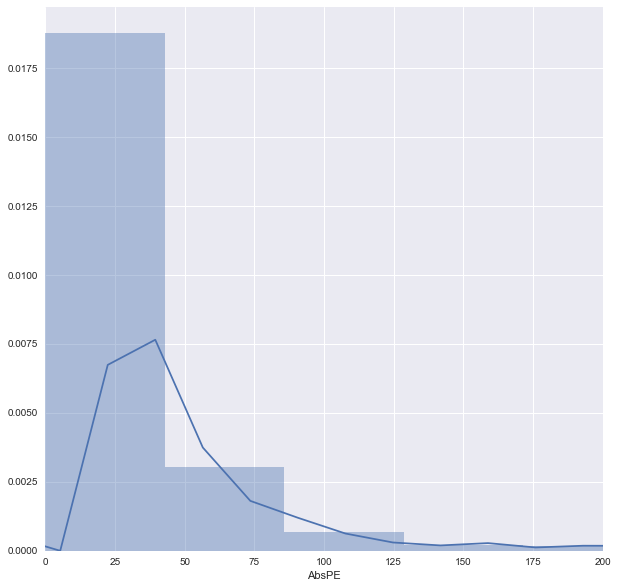

In [24]:
ax=sns.distplot(flatdata_adjusted['AbsPE'])
ax.figure.set_size_inches(10,10)
ax.set_xlim(-0.2,200)

# Project Level Inaccuracy
Group by Internal Project ID and take summation of the Weighted Percent Error column and then take the Absolute Value. Taking the absolute value later because that way we can assess the actual accuracy of forecast for each project, since positive and negative values will interact.

Creating another column to see how taking the Absolute Weighted Percent Error will affect.

#### Since we have already weighted the percent error, taking the summation will give the average error for a particular project.

In [25]:
project_error1 = flatdata_adjusted['WeightedPE'].groupby(flatdata_adjusted['InternalProjectID']).sum().to_frame(name='TotalError')
project_error2 = flatdata_adjusted['AbsWPE'].groupby(flatdata_adjusted['InternalProjectID']).sum().to_frame(name='TotalAbsError')
#project_error=pd.merge(project_error1,project_error2,left_on='InternalProjectID')
#project_error2


,TotalAbsError
InternalProjectID,
0,2.063953
100061,33.823529
100099,3.636364
100117,3.488372
10914,4.356097
111111,2.000000
12343,0.004011
12356,7.099771
13234,1.304348


In [29]:
project_error1

,TotalError
InternalProjectID,
0,2.063953
100061,33.823529
100099,-3.636364
100117,-3.488372
10914,3.213174
111111,-2.000000
12343,0.004011
12356,7.099771
13234,1.304348


In [29]:
project_error1=project_error1.assign(AbsTotalError=np.abs(project_error1['TotalError']))
project_error1

NameError: name 'project_error' is not defined

### Project level Analysis Results

In [30]:
project_error1.describe() #summed first, then absolute value of average error was taken

,TotalError
count,1524.000000
mean,-1.430008
std,81.309569
min,-1746.348548
25%,-3.339094
50%,6.968074
75%,17.606146
max,100.000000


In [31]:
project_error2.describe() #the absolute weighted error was taken and then summed, which creates the average

,TotalAbsError
count,1524.000000
mean,25.861842
std,77.767291
min,0.000000
25%,7.336882
50%,14.406830
75%,25.169721
max,1746.348548


(-100, 100)

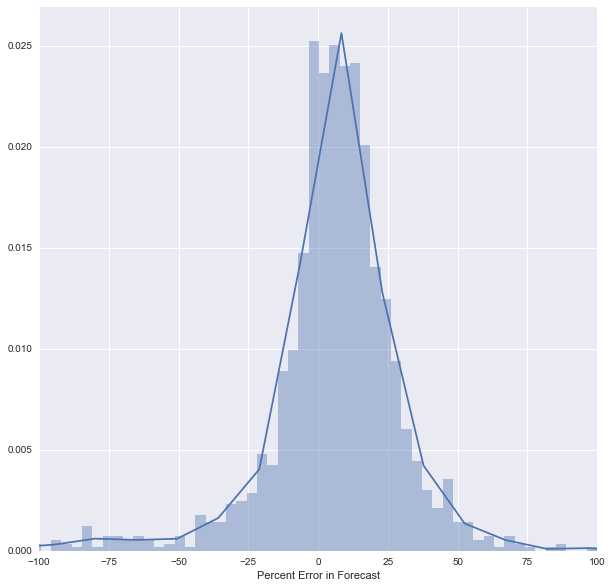

In [46]:
ax=sns.distplot(project_error1['TotalError'],bins=500,kde=True,axlabel='Percent Error in Forecast')
ax.figure.set_size_inches(10,10)
ax.set_xlim(-100,100)

In [43]:
ax.get_figure?

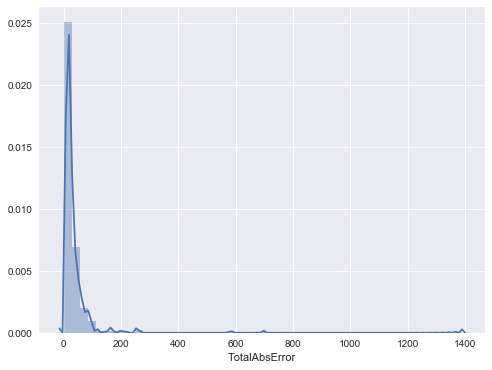

In [105]:
ax=sns.distplot(project_error2['TotalAbsError'])
ax.figure.set_size_inches(8,6)